In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from keras.datasets import mnist
#from sklearn import datasets
#from sklearn.datasets import fetch_mldata
#mnist = fetch_mldata('MNIST original')

# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("Training input shape: ", X_train.shape)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1) #tf ordering, depth/channels at last index
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train -= 127.5
X_train /= 127.5
X_test -= 127.5
X_test /= 127.5 # scaling to [-1,1] matching tanh output of generator

print("Training input shape reshaped: ",X_train.shape)

/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using TensorFlow backend.


Training input shape:  (60000, 28, 28)
Training input shape reshaped:  (60000, 28, 28, 1)


In [2]:
import pickle
#pickle.dump([X_train,y_train,X_test,y_test],open("mnist.pkl","wb"))

In [3]:
# generator
from keras.layers import Embedding, Dense, Input, Flatten, Activation, LeakyReLU, merge
from keras.layers import Reshape, BatchNormalization, Dropout, Conv2D, Conv2DTranspose
from keras.layers.merge import Multiply
from keras.models import Model
from keras.optimizers import Adam, RMSprop
latent_size = 100

g_opt = RMSprop(lr=0.0004,clipvalue=1,decay=1e-8)
g_inp_z = Input(shape=(latent_size,))
g_inp_int = Input(shape=(1,), dtype='int32')



x_int = Flatten()(Embedding(10,latent_size,embeddings_initializer='glorot_normal',input_shape=(1,))(g_inp_int))
x = Multiply([g_inp_z,x_int])

x = Dense(128*14*14)(x)
x = LeakyReLU()(x)

x = Reshape(target_shape=(14,14,128))(x)
x = Conv2D(256,5,padding="same")(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(256,4,strides=2,padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(256,5,padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(256,5,padding='same')(x)
x = LeakyReLU()(x)
#image now at 256,28,28
g_out = Conv2D(1,7,padding='same',activation='tanh')(x)

generator = Model([g_inp_z,g_inp_int],g_out)
#generator.compile(loss='binary_crossentropy',optimizer=g_opt)
#generator.summary()

/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:15: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `sum`, `concatenate`, etc.
/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [4]:
#discriminator

d_opt = RMSprop(lr=0.0008,clipvalue=1,decay=1e-8)
d_input = Input(shape=X_train.shape[1:],name="dis_in")

x = Conv2D(128,(3,3),padding='same',strides=(1,1),input_shape=X_train.shape[1:])(d_input)
x = LeakyReLU()(x)

x = Conv2D(128,(4,4),padding='same',strides=(2,2))(x)
x = LeakyReLU()(x)

x = Conv2D(128,(4,4),padding='same',strides=(2,2))(x)
x = LeakyReLU()(x)

x = Conv2D(128,(4,4),padding='same',strides=(2,2))(x)
x = LeakyReLU()(x)

x = Flatten()(x)
x = Dropout(0.4)(x)
fake = Dense(1,activation='sigmoid',name='decision')(x)
aux = Dense(10,activation='softmax',name='auxil')(x)

discriminator = Model(d_input,[fake,aux])
discriminator.compile(loss=['binary_crossentropy','sparse_categorical_crossentropy'],optimizer=d_opt)
#discriminator.summary()

In [5]:
# fit discriminator to avoid batchnorm bug in keras: https://github.com/fchollet/keras/pull/5647
nb_pretrain = 1
discriminator.fit(X_test[:nb_pretrain],[np.ones(nb_pretrain),y_test[:nb_pretrain]],nb_epoch=1)

/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/keras/engine/training.py:1393: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
1/1 [==============================] - 0s - loss: 3.1052 - decision_loss: 0.6903 - auxil_loss: 2.4149


In [5]:
#gan
gan_inp_z = Input(shape=(latent_size,),name="input_ganZ")
gan_inp_int = Input(shape=(1,), dtype='int32',name='input_ganInt')

H = generator([gan_inp_z,gan_inp_int])
discriminator.trainable = False
fake2,aux2 = discriminator(H)
gan = Model([gan_inp_z,gan_inp_int],[fake2,aux2])
gan.compile(loss=['binary_crossentropy','sparse_categorical_crossentropy'], optimizer = g_opt)
gan.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_ganZ (InputLayer)          (None, 100)           0                                            
____________________________________________________________________________________________________
input_ganInt (InputLayer)        (None, 1)             0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, 28, 28, 1)     7693033                                      
____________________________________________________________________________________________________
model_2 (Model)                  [(None, 1), (None, 10 810635                                       
Total params: 8,503,668.0
Trainable params: 8,503,668.0
Non-trainable params: 0.0
_________

In [6]:
# set up loss storage vector
#losses = {"df":[],'daux':[], "gf":[], 'gaux':[]}

#helper fcts

from IPython import display

def plot_loss(losses,start=0):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(12,6))
        plt.plot(losses["df"][start:], label='dis decision loss')
        plt.plot(losses['daux'][start:], label='dis aux loss')
        plt.plot(losses["gf"][start:], label='gen decision loss')
        plt.plot(losses["gaux"][start:], label='gen aux loss')
        plt.legend()
        plt.show()
        

def plot_gen(n_ex=16,dim=(2,8), figsize=(10,3) ):
    noise = np.random.normal(0,1,size=[n_ex,latent_size])
    noise_int = np.mod(range(n_ex),10)
    generated_images = generator.predict([noise,noise_int])

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,0]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
def get_gradients(model):
    """Return the gradient of every trainable weight in model

    Parameters
    -----------
    model : a keras model instance

    First, find all tensors which are trainable in the model. Surprisingly,
    `model.trainable_weights` will return tensors for which
    trainable=False has been set on their layer (last time I checked), hence the extra check.
    Next, get the gradients of the loss with respect to the weights.

    """
    #weights = [tensor for tensor in model.trainable_weights if model.get_layer(tensor.name[:-2]).trainable]
    weights = model.trainable_weights
    optimizer = model.optimizer

    return optimizer.get_gradients(model.total_loss, weights)

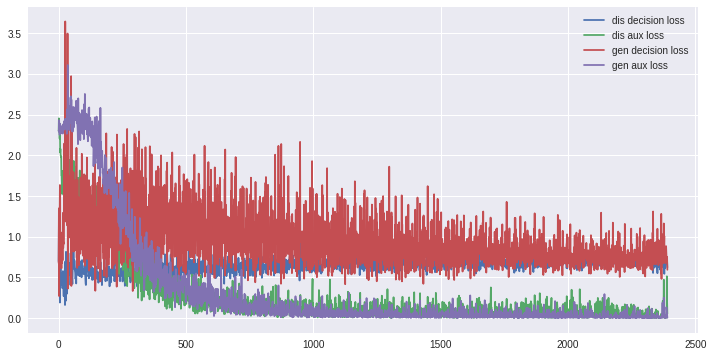

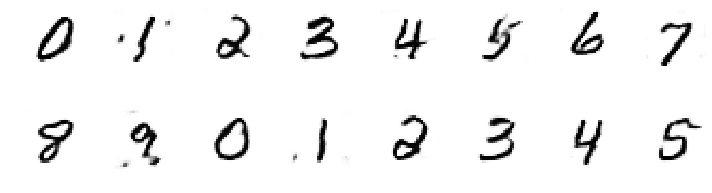

2399/2400 [============================>.] - ETA: 0s

In [7]:
#training
from keras.utils.generic_utils import Progbar
nb_epochs = 1
batch_size = 25


for ep in range(nb_epochs):
    
    num_batches = int(np.floor(X_train.shape[0]/batch_size))
    progress_bar = Progbar(target=num_batches-5)
    for i in range(num_batches):
        if(i >= 5):
            progress_bar.update(i-5)
        # generate a new batch of noise
        noise_z = np.random.normal(0, 1, (batch_size, latent_size))
        noise_int = np.random.randint(0,10,size=(batch_size),dtype='int32')
        image_gen = generator.predict([noise_z,noise_int])

        # get a batch of real images
        image_batch = X_train[i * batch_size:(i + 1) * batch_size]
        label_batch = y_train[i * batch_size:(i + 1) * batch_size]
        
        discriminator.trainable = True
        X_batch = np.concatenate((image_batch,image_gen))
        y_auxbatch = np.concatenate((label_batch,noise_int))
        y_dbatch = np.concatenate((np.ones(batch_size) ,
                                   np.zeros(batch_size) ))
        
        y_dbatch += 0.05 * np.random.random(y_dbatch.shape)
        
        #y_dbatch[np.random.randint(0,batch_size,size=3)] = 0
        
        d_l = discriminator.train_on_batch(X_batch,[y_dbatch,y_auxbatch])
        losses['df'].append(d_l[1])
        losses['daux'].append(d_l[2])
        
        
        #train generator on gan with d untrainable
        discriminator.trainable = False
        noise_z = np.random.normal(0, 1, (batch_size*2, latent_size))
        noise_int = np.random.randint(0,10,size=(batch_size*2))
        g_l = gan.train_on_batch([noise_z,noise_int],
                                 [np.ones(batch_size*2)+np.random.uniform(-0.1,0.1,size=(batch_size*2)),noise_int])

        losses['gf'].append(g_l[1])
        losses['gaux'].append(g_l[2])
        
        if(i % 10 == 0):
            plot_loss(losses)
            plot_gen(16)
        
        

In [18]:
import tensorflow as tf

with tf.Session() as sess:

    get_gradients(discriminator)[0].eval()
    
sess.close()

IndexError: list index out of range

In [20]:
discriminator.count_params

<bound method Layer.count_params of <keras.engine.training.Model object at 0x7fa69820ca20>>

In [14]:
len(losses['daux'])

122